In [1]:
VERSION = "20210201"
!pip install timm  > /dev/null
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION
!pip install pytorch-lightning==1.1.5 > /dev/null
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  58136      0 --:--:-- --:--:-- --:--:-- 58804
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20210201 ...
Found existing installation: torch 1.7.0
Uninstalling torch-1.7.0:
  Successfully uninstalled torch-1.7.0
Found existing installation: torchvision 0.8.1
Uninstalling torchvision-0.8.1:
Done updating TPU runtime
  Successfully uninstalled torchvision-0.8.1
Copying gs://tpu-pytorch/wheels/torch-nightly+20210201-cp37-cp37m-linux_x86_64.whl...
| [1 files][123.5 MiB/123.5 MiB]                                                
Operation completed over 1 objects/123.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20210201-cp37-cp37m-linux_x86_64.whl...
| [1 files][132.3 MiB/132.3 MiB]                                            

In [2]:
!ls ../input/ranzcr-chest-xray-pretrainer/

Output		    __results__.html   resnet200d_fold0.pth
__notebook__.ipynb  __results___files  resnet200d_fold0_end.pth
__output__.json     custom.css	       resnet200d_fold0_maxacc.pth


In [3]:
import os
import gc
import math
import random
import pandas as pd
import numpy as np
from   collections import OrderedDict 

import torch
import torch.nn as nn
from   torch.nn import CrossEntropyLoss, MSELoss
from   torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from   torch.nn import Parameter
from   torch.utils.data import Dataset, DataLoader
from   fastai.losses import LabelSmoothingCrossEntropy
from   warmup_scheduler import GradualWarmupScheduler

from   sklearn import preprocessing
from   sklearn.metrics import accuracy_score
from   sklearn.model_selection import StratifiedKFold, GroupKFold

import timm
import albumentations as A
from   albumentations.pytorch import ToTensorV2
from   albumentations.core.transforms_interface import DualTransform
from   albumentations.augmentations import functional as AF
import cv2

from   tqdm import tqdm
from   pprint import pprint
from   functools import partial
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings ("ignore")

import pytorch_lightning as pl
from   pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning.metrics.functional as FM

OSError: /opt/conda/lib/python3.7/site-packages/torchtext/_torchtext.so: undefined symbol: _ZNK3c104Type14isSubtypeOfExtESt10shared_ptrIS0_EPSo

In [4]:
import pytorch_lightning as pl
from   pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning.metrics.functional as FM

In [5]:
import pytorch_lightning as pl
from   pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning.metrics.functional as FM

In [6]:
import torch_xla.core.xla_model as xm
xm.xla_device ()

device(type='xla', index=1)

In [7]:
class CFG:
    device       = torch.device ('cuda:0' if torch.cuda.is_available () else 'cpu')
    num_workers  = 8
    model_name   = 'resnet200d' # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b7_ns']
    size         = 512  # [64, 128, 224, 384, 512]
    train        = True
    freeze       = False     # this is updated during training   
    freeze_epo   = 0 # GradualWarmupSchedulerV2
    warmup_epo   = 1 # GradualWarmupSchedulerV2
    cosine_epo   = 3 # GradualWarmupSchedulerV2
    epochs       = freeze_epo + warmup_epo + cosine_epo # [GradualWarmupSchedulerV2, n_epochs]
    epochsNx     = 1
    min_unfreez_layer = 2 # allowed to unfreeze layers 11 to 5 only and not less than 5
    criterion    = 'BCEWithLogitsLoss'    # ['CrossEntropyLoss', 'BCEWithLogitsLoss', 'SmoothBCEwithLogits']
    batch_size   = 20 #[10, 32, 64]
    lr           = 1e-3
    weight_decay = 1e-6
    gradient_clip_val = 100
    tta          = 3 
    seed         = 42
    target_size  = -1    # init below
    n_fold       = 5
    train_fold   = [0] #, 1, 2, 3, 4]
    # infer_fold = [0, 1, 2, 3, 4]
    img_ext      = '.jpg'
    img_col      = "StudyInstanceUID"
    label_cols   = [
                    'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                    'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                    'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                    'Swan Ganz Catheter Present'
    ]
    scheduler  = 'GradualWarmupSchedulerV2' # ['ReduceLROnPlateau']
    T_0        = 10                         # CosineAnnealingWarmRestarts
    model_infer_path_prefix = "../input/ranzcr-chest-xray-pretrainer" 
    model_train_path_prefix = "."
    train_path = '../input/ranzcr-clip-catheter-line-classification/train'
    train_csv  = '../input/ranzcr-clip-catheter-line-classification/train.csv'
    test_path  = '../input/ranzcr-clip-catheter-line-classification/test'
    test_csv   = '../input/ranzcr-clip-catheter-line-classification/test.csv'
    output_dir = 'Output/'
    
    # smoothing    = 0.1
    # freeze_epo = 1 # after these epochs, gradually unfreeze top layers
    # gradual_unfreez_epo = 7
    # IMG_MEAN     = [0.485, 0.456, 0.406] #Mean for normalization Transform cassava = [0.4303, 0.4967, 0.3134] imgnet = [0.485, 0.456, 0.406]
    # IMG_STD      = [0.229, 0.224, 0.225] #STD for normalization Transform cassava = [0.2142, 0.2191, 0.1954] imgnet = [0.229, 0.224, 0.225]            
    
CFG.target_size = len (CFG.label_cols)

In [8]:
def init_logger (log_file=CFG.output_dir+'train.log'):
    
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger (__name__)
    logger.setLevel (INFO)
    handler1 = StreamHandler ()
    handler1.setFormatter (Formatter ("%(message)s"))
    handler2 = FileHandler (filename=log_file)
    handler2.setFormatter (Formatter ("%(message)s"))
    logger.addHandler (handler1)
    logger.addHandler (handler2)
    return logger

In [9]:
def seed_everything (seed):
    
    random.seed (seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    return

# Augmentation Dataset

In [10]:
# NOTE: We don't normalize here since it all gets dark
# if advprop:           # for models using advprop pretrained weights
#     normalize = transforms.Lambda(lambda img: img * 2.0 - 1.0)
# else:
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
train_transforms = A.Compose ([
        A.HorizontalFlip (p=0.5),
        A.Resize (CFG.size, CFG.size),
        ToTensorV2 (p=1.0),
])
valid_transforms = A.Compose ([
        A.Resize (CFG.size, CFG.size),
        ToTensorV2 (p=1.0),
])

def get_transforms (data='train'):
    
    if 'train' in data:
        return train_transforms
    elif 'valid' in data:
        return valid_transforms
    else:
        return valid_transforms

In [11]:
class ImgDataset (Dataset):
    
    def __init__(self, df, img_file_colname=CFG.img_col, label_cols=CFG.label_cols, 
                 transform=get_transforms(), img_dir=CFG.train_path, img_ext=CFG.img_ext):
        
        super ().__init__()
        self.df               = df.reset_index (drop=True)
        self.img_ext          = CFG.img_ext
        self.img_dir          = img_dir
        self.label_cols       = label_cols
        self.img_file_colname = img_file_colname
        self.transform        = transform
        return
    
    def __len__(self):
        return self.df.shape[0]        # TODO: fix this
    
    def __getitem__(self, idx):
        
        file_name = self.df[self.img_file_colname][idx].replace (self.img_ext, '') + self.img_ext
        file_path = f'{self.img_dir}/{file_name}'                          #;print ('file_path =', file_path)
        image     = cv2.imread (file_path)                                 #;print ('image.shape =', image.shape)
        image     = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform (image=image)['image'].float ()
        else:
            image = ToTensorV2 ()(image = image)["image"].float ()
        
        if len (self.label_cols) > 0:
            label = torch.tensor (self.df.loc[idx, self.label_cols]).int ()
            return image, label
        return image

In [12]:
def getFolds ():
    
    train_folds_df = pd.read_csv (CFG.train_csv)
    label = train_folds_df[CFG.label_cols]
    if len (CFG.label_cols) > 1:
        label = train_folds_df[CFG.label_cols[0]]
        
    skf = StratifiedKFold (n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate (skf.split (train_folds_df, label)):
        train_folds_df.loc[val_index, 'fold'] = int (n)
    train_folds_df['fold'] = train_folds_df['fold'].astype (int)
    # print (train_folds_df.groupby (['fold', label]).size ())
        
    return train_folds_df

10

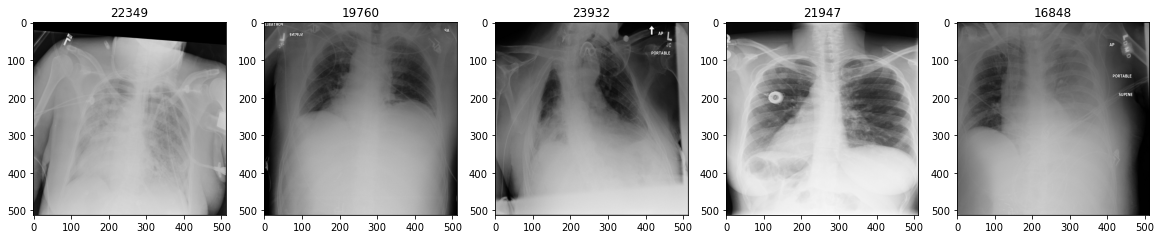

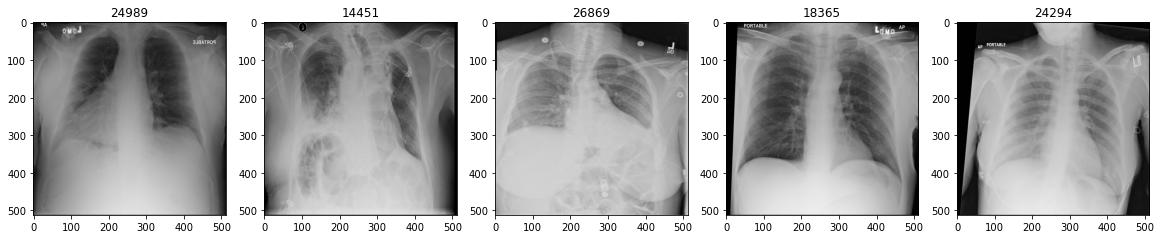

In [13]:
def plot_imgs (dataset_show):
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range (2):
        f, axarr = plt.subplots (1,5)
        for p in range (5):
            idx = np.random.randint (0, len (dataset_show))
            img, label = dataset_show[idx]                                    #;print (img.size())
            img = img.byte ()
            axarr[p].imshow (img.permute(1, 2, 0))
            axarr[p].set_title (idx)
    return

TR_DATASET = ImgDataset (getFolds ())
plot_imgs (TR_DATASET)
del TR_DATASET
gc.collect ()

> # Loss Functions

In [14]:
# this works for only 1 label, not multi-label target.
class SmoothBCEwLogits (_WeightedLoss):
    
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [15]:
def get_criterion ():
    
    if CFG.criterion=='CrossEntropyLoss':
        criterion = LabelSmoothingCrossEntropy ()
    elif CFG.criterion=='SmoothBCEwithLogits':
        criterion = SmoothBCEwLogits (smoothing=CFG.smoothing)
    elif CFG.criterion=='BCEWithLogitsLoss':
        criterion =  nn.BCEWithLogitsLoss ()
    return criterion

In [16]:
class GradualWarmupSchedulerV2 (GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [17]:
def get_scheduler (optimizer):
    
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau (optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='GradualWarmupSchedulerV2':
            scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts (optimizer, CFG.cosine_epo)
            scheduler_warmup = GradualWarmupSchedulerV2 (optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler_cosine)
            scheduler=scheduler_warmup
        return scheduler

In [18]:
# ====================================================
# MODEL
# ====================================================
class CustomResNet (pl.LightningModule):
    def __init__(self, model_name=CFG.model_name, pretrained=False, lossFn=None, 
                 train_dataset=None, valid_dataset=None):
        
        super().__init__()
        self.model         = timm.create_model(model_name, pretrained=pretrained)
        n_features         = self.model.fc.in_features
        self.model.fc      = nn.Linear (n_features, CFG.target_size)
        self.loss          = lossFn
        self.batch_size    = CFG.batch_size
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.lr            = CFG.lr
        return
    
    def forward (self, x):
        x = self.model (x)        
        return x
    
    def freeze (self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True
        return
    
    def unfreeze (self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
        return
    
    def configure_optimizers (self):
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        optimizer = torch.optim.AdamW (self.parameters (), lr=self.lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=CFG.weight_decay)
        scheduler = get_scheduler (optimizer)
        return [optimizer], [scheduler]

    def training_step (self, batch, batch_idx):
        x, y = batch
        
        # implement your own
        y_logits= self (x)
        y       = y.type_as (y_logits)
        tr_loss = self.loss (y_logits, y)
        logger_logs = {'train_loss': tr_loss}     # optional (MUST ALL BE TENSORS)
        # if using TestTubeLogger or TensorBoardLogger you can nest scalars
        logger_logs = {'losses': logger_logs}     # optional (MUST ALL BE TENSORS)
        output = {
            'loss': tr_loss, # required
            'progress_bar': {'train_loss': tr_loss}, # optional (MUST ALL BE TENSORS)
            'log': logger_logs
        }
        return output
    
    def training_epoch_end (self, outputs):
        
        avg_train_loss = 0
        for output in outputs:
            avg_train_loss += output['loss']
        avg_train_loss /= len (outputs)
        
        # log training accuracy at the end of an epoch
        results = {
            'loss' : avg_train_loss,
            'log': {'train_loss': avg_train_loss.item ()},
            'progress_bar': {'train_loss': avg_train_loss},
        }
        return results
    
    def validation_step (self, batch, batch_idx):
        
        x, y     = batch
        y_logits = self (x)
        y        = y.type_as (y_logits)
        loss_val = self.loss (y_logits, y)
        
        y_hat    = torch.sigmoid (y_logits)              # returns sigmoid probs through self.forward ()
        y_hat    = torch.round (y_hat).int ()
        y        = y.int ()
        val_acc  = FM.accuracy (y_hat, y)
        logger_logs = {'valid_loss': loss_val, 'valid_acc':val_acc}  
        logger_logs = {'losses_acc': logger_logs}                    
        output   = OrderedDict ({
            'valid_loss': loss_val,
            'valid_acc' : val_acc, 
            'progress_bar': {'valid_loss':loss_val, 'valid_acc':val_acc}, 
            'log': logger_logs
        })
        return output

    def validation_epoch_end (self, outputs):
        
        avg_val_loss = torch.stack ([x['valid_loss'] for x in outputs]).mean ()
        avg_val_acc  = torch.stack ([x['valid_acc'] for x in outputs]).mean ()
        tqdm_dict    = {'valid_acc': avg_val_acc.item ()}
        results      = {
            'loss': avg_val_loss,
            'progress_bar': tqdm_dict,
            'log': {'valid_acc': avg_val_acc.item (), 'valid_loss': avg_val_loss.item ()}
        }
        return results
    
    def train_dataloader (self):        
        loader = DataLoader (self.train_dataset, batch_size=CFG.batch_size, num_workers=CFG.num_workers) #num_workers=4
        return loader

    def val_dataloader (self):
        loader = DataLoader (self.valid_dataset, batch_size=CFG.batch_size, num_workers=CFG.num_workers) #num_workers=4
        return loader
    
    
class CustomResNext (pl.LightningModule):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
            

class CustomEfficientNet (pl.LightningModule):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model (CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
        
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.classifier.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
    
    
class CustomDeiT (pl.LightningModule):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True

    
class CustomViT (pl.LightningModule):
    
    def __init__(self, model_name=CFG.model_name, pretrained=False):
                 # min_unfreez_layer=CFG.min_unfreez_layer, max_layer_no=CFG.max_layer_no):
        
        super().__init__()
        self.model      = timm.create_model(model_name, pretrained=pretrained)
        n_features      = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)
        # self.min_unfreez_layer = min_unfreez_layer
        # self.max_layer_no      = max_layer_no
        return

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
        return
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
        return
    
    # def unfreeze_layer (self, layer_no=11):
    #     # unfreeze a particular layer
    #     if layer_no >= self.min_unfreez_layer and layer_no <= self.max_layer_no:
    #         for param in self.model.blocks[layer_no].parameters ():
    #             param.requires_grad = False
    #     return

In [19]:
def load_state (model_path, model):
    
    state_dict = None
    try:  # single GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))['model']
        model.load_state_dict (state_dict, strict=True)
    except:  # multi GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))
        state_dict = {k[7:] if k.startswith ('module.') else k: state_dict[k] for k in state_dict.keys ()}
        model.load_state_dict (state_dict)
    return state_dict

In [20]:
def getModel (fold, isTrain, train_dataset=None, valid_dataset=None):
    
    model = None
    if 'deit_' in CFG.model_name:
        model = CustomDeiT (model_name=CFG.model_name, pretrained=isTrain)
    elif 'vit_' in CFG.model_name:
        model = CustomViT (model_name=CFG.model_name, pretrained=isTrain)
    elif 'resnext' in CFG.model_name:
        model = CustomResNext (CFG.model_name, pretrained=isTrain)
    elif 'resnet' in CFG.model_name:
        model = CustomResNet (CFG.model_name, pretrained=False, lossFn=get_criterion (), # TODO: pretrained=isTrain
                              train_dataset=train_dataset, valid_dataset=valid_dataset)
    elif 'efficientnet' in CFG.model_name:
        model = CustomEfficientNet (CFG.model_name, pretrained=isTrain)  
    if isTrain:
        
        # TODO: comment these
        model_path = f'{CFG.model_infer_path_prefix}/{CFG.model_name}_fold{fold}_end.pth'
        if os.path.exists (model_path):
            print ('loading model from', model_path)
            load_state (model_path, model)  
    else:
        
        # TODO: change CFG.model_train_path_prefix to CFG.model_infer_path_prefix
        model_path = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_end.pt'
        print ('loading model from', model_path)
        load_state (model_path, model)
        
    if CFG.freeze:        
        model.freeze ()
    else:
        model.unfreeze ()
    return model

In [21]:
def fit_epochs (fold, callbacks, max_acc, model):
    # tpu_cores=8, 
    trainer = pl.Trainer (tpu_cores=8, max_epochs=CFG.epochs, callbacks=callbacks, auto_lr_find=True,
                          gradient_clip_val=CFG.gradient_clip_val, auto_scale_batch_size=False, #'binsearch',
                          benchmark=True, fast_dev_run=True)                        
    trainer.fit (model)
    # print (trainer.progress_bar_dict)
    acc = trainer.progress_bar_dict['valid_acc']
    
    if acc > max_acc:
        max_acc = acc
    #   print ("Saving Max-Acc model.....")
    #   model.save (f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_maxacc')
    
    # model.save_checkpoint (f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_end.chk')
    torch.save (model.state_dict (), f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_end.pt')
    return max_acc

In [22]:
def train_fold_loop (fold, train_df=getFolds ()):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = train_df[train_df['fold'] != fold].index
    val_idx = train_df[train_df['fold'] == fold].index
    train_folds_df = train_df.loc[trn_idx].reset_index (drop=True)
    valid_folds_df = train_df.loc[val_idx].reset_index (drop=True)    
    train_dataset  = ImgDataset (train_folds_df, transform=get_transforms ('train'))
    valid_dataset  = ImgDataset (valid_folds_df, transform=get_transforms ('valid'))
    model          = getModel (fold, isTrain=True, train_dataset=train_dataset, valid_dataset=valid_dataset)
    max_acc        = 0
    early_stop_cb  = EarlyStopping (monitor='valid_acc', min_delta = 0.001, patience=3, strict=False, verbose=False, mode='max')
    for i in range (CFG.epochsNx):
        
        callbacks  = [early_stop_cb]
        max_acc    = fit_epochs (fold, callbacks, max_acc, model)
    return max_acc

In [23]:
def train_main ():
    
    if CFG.train:
        
        valid_scores = []
        for fold in range (CFG.n_fold):
            if fold in CFG.train_fold:
                valid_scores_fold = train_fold_loop (fold)
                valid_scores_fold = np.array (valid_scores_fold).reshape ((1, -1))
                valid_scores.append (valid_scores_fold)
                
        LOGGER.info (f"========== CV ==========")
        valid_scores = np.vstack (valid_scores)
        valid_scores = np.mean (valid_scores, axis=0)
        print ("CV Scores =", valid_scores)

In [24]:
!mkdir -p /kaggle/working/Output/
!touch /kaggle/working/Output/train.log
gc.collect ()
# model_names = timm.list_models (pretrained=True)
# model_names = timm.list_models ('*resnet*', pretrained=True)
# pprint (model_names)

LOGGER = init_logger ()
seed_everything (seed=CFG.seed)
train_main ()

========== fold: 0 training ==========


loading model from ../input/ranzcr-chest-xray-pretrainer/resnet200d_fold0_end.pth


GPU available: False, used: False
GPU available: False, used: False
TPU available: True, using: 8 TPU cores
TPU available: True, using: 8 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).
training on 8 TPU cores
training on 8 TPU cores
Exception in device=TPU:0: Cannot replicate if number of devices (1) is different from 8
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch_xla/distributed/xla_multiprocessing.py", line 329, in _mp_start_fn
    _start_fn(index, pf_cfg, fn, args)
  File "/opt/conda/lib/python3.7/site-packages/torch_xla/distributed/xla_multiprocessing.py", line 322, in _start_fn
    _setup_replication()
  File "/opt/conda/lib/python3.7/site-packages/torch_xla/distributed/xla_multiprocessing.py", line 315, in _setup_replication
    xm.set_replication(device, [device])
Exception in device=TPU:1: Canno

ProcessExitedException: process 0 terminated with exit code 17

%load_ext tensorboard
%tensorboard --logdir lightning_logs/

# Inference

In [ ]:
def compute_metrics (labels, preds):
    
    # preds   = pred_pr.argmax (-1)             # ;print ('labels.shape=', labels.shape, 'preds.shape=', preds.shape, 'pred_logits.shape=', pred_logits.shape)
    precision, recall, f1, _ = precision_recall_fscore_support (labels, preds, average='macro')
    acc     = accuracy_score (labels, preds)
    mcc     = matthews_corrcoef (labels, preds)   # matthews correlation coefficient
    # softmax = nn.Softmax (dim=1)
    # pred_pr = softmax (torch.tensor (pred_logits))
    # auc     = roc_auc_score (labels, pred_pr[:, 1])
    metrics = {
        'mcc'      : mcc,
        'accuracy' : acc,
        'f1'       : f1,
        'precision': precision,
        'recall'   : recall,
        #'auc'     : auc
    }
    return metrics

In [ ]:
def inference_one_loop (model, data_loader, device):
    model.eval ()
    image_preds_all = []
    pbar = tqdm (enumerate (data_loader), total=len (data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to (device).float ()
        image_preds = None
        with torch.no_grad():
            image_preds = torch.sigmoid (model (imgs)).detach ().cpu ().numpy ()
        image_preds_all += [image_preds]
    
    image_preds_all = np.concatenate (image_preds_all, axis=0)
    return image_preds_all

In [ ]:
def infer ():
    
    # CFG.freeze = True
    tst_preds_avg = []    
    seed_everything (CFG.seed)
    test_df = pd.DataFrame ()
    test_df[CFG.img_col] = list (os.listdir (CFG.test_path))
    test_ds = ImgDataset (test_df, label_cols=[], transform=get_transforms('valid'), img_dir=CFG.test_path)
    print ('len (test_ds) =', len (test_ds)) 
    print ('test_ds[10].shape =', test_ds[10].shape)
    
    tst_loader = DataLoader (
        test_ds, 
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=False,
        pin_memory=False,
    )                                            #;print ('len (tst_loader)=', len (tst_loader))
    for fold in CFG.train_fold:
        
        print ('Inference fold {} started'.format (fold))
        model     = getModel (fold, isTrain=False).to (CFG.device)
        tst_preds = None        
        with torch.no_grad ():
            for _ in range (CFG.tta):
                if tst_preds is None:
                    tst_preds = [1/CFG.tta * inference_one_loop (model, tst_loader, CFG.device)]
                else:
                    tst_preds += [1/CFG.tta * inference_one_loop (model, tst_loader, CFG.device)]
        
        # tst_preds = tst_preds.reshape ((-1, len (CFG.label_cols)))
        if tst_preds_avg is None:
            tst_preds_avg = tst_preds / len (CFG.train_fold)
        else:
            tst_preds_avg += tst_preds / len (CFG.train_fold)
        del model
        torch.cuda.empty_cache ()
        gc.collect ()
    
    # test_df['label'] = np.argmax (tst_preds_avg, axis=-1)  # for softmax
    test_df['label'] = (tst_preds_avg >= 0.5) + 0   # for sigmoid
    print (test_df.head ())
    test_df.to_csv ('submission.csv', index=False)

In [ ]:
# infer ()

In [ ]:
print ('Done !')